## Import libraries

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import rasterio
from rasterio.plot import show
import numpy as np

# LiPAD Data

## Load shapefile

File: ph137404000_fh5yr_30m_10m.shp (Data retrieved from LiPAD), source: https://lipad-fmc.dream.upd.edu.ph/layers/geonode%3Aph137404000_fh5yr_30m_10m

In [19]:
# Read shapefile
gdf = gpd.read_file('ph137404000_fh5yr_30m_10m.shx')

# Display basic information
#print(gdf.crs)  # Coordinate Reference System
print(gdf.total_bounds)  # Bounding box
gdf = gdf.set_crs(epsg=32651, allow_override=True)

[ 282480.1385 1612821.6278  300257.9594 1635573.5916]


In [20]:
# The .dbf file contains attribute data - let's examine it thoroughly
from dbfread import DBF
import os

# Read the DBF file directly
dbf_path = 'ph137404000_fh5yr_30m_10m.dbf'
if os.path.exists(dbf_path):
    table = DBF(dbf_path)
    print("=== DBF FILE STRUCTURE ===")
    print(f"Number of records: {len(table)}")
    print(f"Fields: {table.fields}")

    # Show first few records in detail
    for i, record in enumerate(table):
        if i < 5:  # Show first 5 records
            print(f"Record {i}: {record}")
        else:
            break

=== DBF FILE STRUCTURE ===
Number of records: 6
Fields: [DBFField(name='Var', type='N', address=0, length=9, decimal_count=0, reserved1=0, workarea_id=0, reserved2=0, reserved3=0, set_fields_flag=0, reserved4=b'\x00\x00\x00\x00\x00\x00\x00', index_field_flag=0), DBFField(name='Muncode', type='C', address=9, length=254, decimal_count=0, reserved1=0, workarea_id=0, reserved2=0, reserved3=0, set_fields_flag=0, reserved4=b'\x00\x00\x00\x00\x00\x00\x00', index_field_flag=0)]
Record 0: OrderedDict({'Var': -2, 'Muncode': 'PH137404000'})
Record 1: OrderedDict({'Var': -1, 'Muncode': 'PH137404000'})
Record 2: OrderedDict({'Var': 0, 'Muncode': 'PH137404000'})
Record 3: OrderedDict({'Var': 1, 'Muncode': 'PH137404000'})
Record 4: OrderedDict({'Var': 2, 'Muncode': 'PH137404000'})


## Exploratory Data Analysis

In [21]:
# Basic structure
print(f"Shape: {gdf.shape}")
print(f"Columns: {gdf.columns.tolist()}")

# Check geometry types
print(f"\nGeometry types:")
print(gdf.geometry.type.value_counts())

# Spatial extent
print(f"\nSpatial bounds:")
print(gdf.total_bounds)

# Check for missing values
print(f"\nMissing values per column:")
print(gdf.isnull().sum())

# Sample of attribute data
gdf.head()

Shape: (6, 3)
Columns: ['Var', 'Muncode', 'geometry']

Geometry types:
MultiPolygon    5
Polygon         1
Name: count, dtype: int64

Spatial bounds:
[ 282480.1385 1612821.6278  300257.9594 1635573.5916]

Missing values per column:
Var         0
Muncode     0
geometry    0
dtype: int64


Var      Muncode                                           geometry
0   -2  PH137404000  POLYGON ((299257.959 1634465.146, 299203.447 1...
1   -1  PH137404000  MULTIPOLYGON (((287825 1613625, 287825 1613615...
2    0  PH137404000  MULTIPOLYGON (((284298 1612821.628, 284278 161...
3    1  PH137404000  MULTIPOLYGON (((283248 1612821.628, 283238 161...
4    2  PH137404000  MULTIPOLYGON (((286648 1612821.628, 286638 161...

<Figure size 1200x800 with 0 Axes>

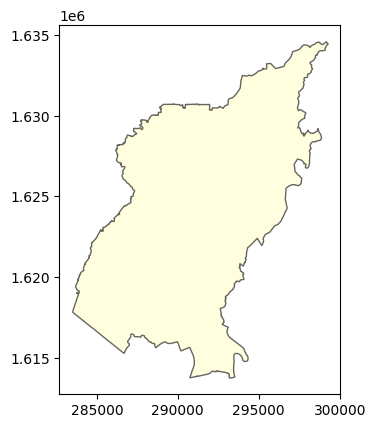

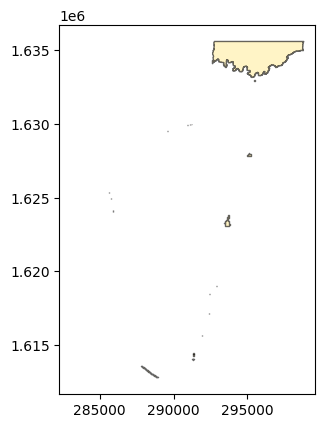

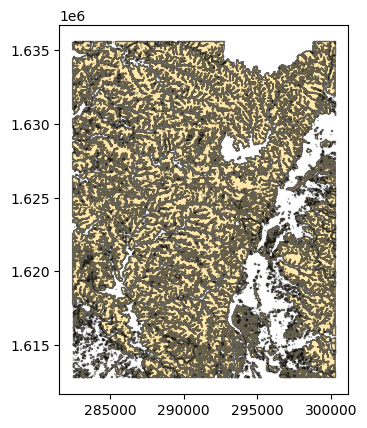

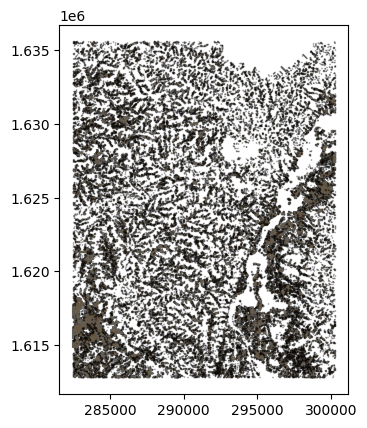

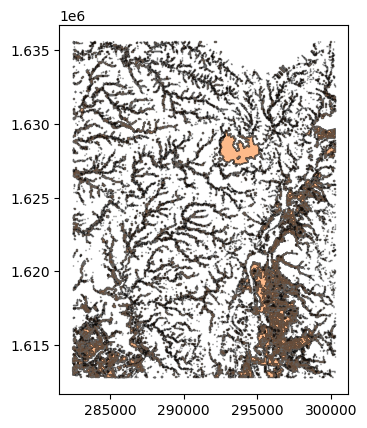

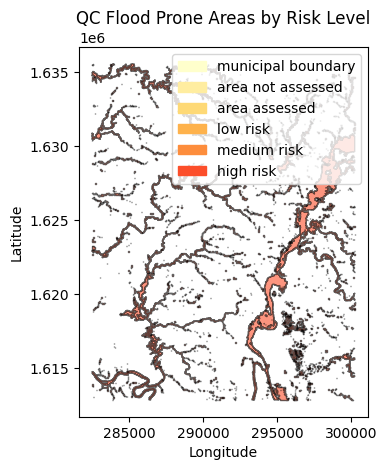

In [22]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Define the dictionary for labels
var_labels = {
    -2: "municipal boundary",
    -1: "area not assessed",
    0: "area assessed",
    1: "low risk",
    2: "medium risk",
    3: "high risk"
}


# Get unique Var values and sort them
unique_vars = sorted(gdf['Var'].unique())

# Define a list of warm colors (ensure enough colors for unique_vars)
warm_colors = ['#FFFFCC', '#FFEDA0', '#FED976', '#FEB24C', '#FD8D3C', '#FC4E2A', '#E31A1C', '#BD0026', '#800026'] # Example warm colors

# Create a dictionary to map Var values to colors
color_map = {var: warm_colors[i % len(warm_colors)] for i, var in enumerate(unique_vars)}

plt.figure(figsize=(12, 8))

legend_handles = []

# Iterate through unique Var values and plot
for var in unique_vars:
    color = color_map[var]
    gdf[gdf['Var'] == var].plot(alpha=0.6, edgecolor='black', color=color)
    label = var_labels.get(var, f'Var = {var}') # Get label from dictionary, fallback to default if not found
    patch = mpatches.Patch(color=color, label=label)
    legend_handles.append(patch)


plt.title('QC Flood Prone Areas by Risk Level')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(handles=legend_handles)
plt.show()

In [23]:
## Use folium for interactivity
import folium
import geopandas as gpd

gdf_var3 = gdf[gdf['Var'] == 3].copy()
boundary = gdf[gdf['Var'] == -2].copy()

high_risk = gpd.sjoin(
    left_df = gdf_var3,
    right_df = boundary,
    how='inner',
    predicate='intersects'
)

high_risk_geo = high_risk.to_crs(epsg=4326)

# Get the centroid
high_risk_projected = high_risk.to_crs(epsg=32651) # Using the original projected CRS

# Calculate the centroid of the projected data
center_projected = high_risk_projected.geometry.unary_union.centroid # Using unary_union for potentially multiple polygons

# Reproject the centroid to EPSG:4326 for use with Folium
center_geo = gpd.GeoSeries([center_projected], crs='epsg:32651').to_crs(epsg=4326).iloc[0]

In [24]:
## Highest risk areas
m = folium.Map(location=[center_geo.y, center_geo.x], zoom_start=12)

folium.GeoJson(
    high_risk_geo,
    name=f'Var = {3}', # Layer name for Layer Control
    tooltip=folium.features.GeoJsonTooltip(fields=['Var_left'], aliases=['Risk level:']) # Add a simple tooltip
).add_to(m)

folium.LayerControl().add_to(m)

m

Flood Routing Algorithm

In [25]:
import geopandas as gpd
import numpy as np
import networkx as nx
from shapely.geometry import Point, LineString, box
from scipy.spatial import cKDTree
import folium
import warnings
from numba import jit
import pickle
from pathlib import Path
warnings.filterwarnings('ignore')


class OptimizedFloodEvacuationRouter:
    """
    Optimized router with configurable flood-layer simplification & dissolution
    to reduce map-rendering load.
    """

    def __init__(self, flood_gdf, grid_resolution=50, cache_dir='./cache',
                 flood_simplify_tol_m=200, flood_dissolve=True):
        """
        flood_simplify_tol_m: default simplify tolerance in meters (applied in projected CRS).
            Larger -> simpler geometry -> faster rendering.
        flood_dissolve: if True, dissolve polygons by 'Var' to reduce number of features.
        """
        # Convert flood_gdf to a projected CRS for distance calculations & simplification
        self.flood_gdf = flood_gdf.to_crs(epsg=32651)
        self.grid_resolution = grid_resolution
        self.graph = None
        self.node_positions = None  # Cached for fast lookups (numpy array Nx2)
        self.evacuation_centers = []
        self.evacuation_names = []
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)

        # Pre-compute flood bounds for efficiency
        self.minx, self.miny, self.maxx, self.maxy = self.flood_gdf.total_bounds

        # Flood layer simplification settings and cache
        self.flood_simplify_tol_m = flood_simplify_tol_m
        self.flood_dissolve = flood_dissolve
        self._simplified_flood_gdf = None  # cached simplified GeoDataFrame (projected CRS)

    def set_evacuation_centers(self, centers_data):
        """Set evacuation center locations.

        Accepts:
        - list of dicts with keys 'name','lat','lon'
        - list of (lat, lon) tuples (lat, lon)
        """
        if len(centers_data) == 0:
            self.evacuation_centers = []
            self.evacuation_names = []
            return

        if isinstance(centers_data[0], dict):
            self.evacuation_names = [c.get('name', f"Center {i+1}") for i, c in enumerate(centers_data)]
            points = [Point(c['lon'], c['lat']) for c in centers_data]
        else:
            # Support simple list of tuples assumed as (lat, lon)
            self.evacuation_names = [f"Center {i+1}" for i in range(len(centers_data))]
            points = [Point(lon, lat) for lat, lon in centers_data]

        # Create GeoSeries in WGS84 then project to working CRS
        self.evacuation_centers = gpd.GeoSeries(points, crs='epsg:4326').to_crs(epsg=32651)

    def _get_cache_path(self):
        """Generate cache file path based on parameters."""
        bounds_str = f"{int(self.minx)}_{int(self.maxx)}_{int(self.miny)}_{int(self.maxy)}"
        return self.cache_dir / f"router_grid{self.grid_resolution}_{bounds_str}.pkl"

    def load_from_cache(self):
        """Load pre-built network from cache."""
        cache_path = self._get_cache_path()
        if cache_path.exists():
            try:
                with open(cache_path, 'rb') as f:
                    cache_data = pickle.load(f)
                self.graph = cache_data['graph']
                self.node_positions = cache_data['node_positions']
                return True
            except Exception as e:
                # If cache is corrupted, ignore and rebuild
                print(f"Warning: failed to load cache ({e}). Rebuilding.")
                return False
        return False

    def save_to_cache(self):
        """Save built network to cache."""
        cache_path = self._get_cache_path()
        cache_data = {
            'graph': self.graph,
            'node_positions': self.node_positions
        }
        with open(cache_path, 'wb') as f:
            pickle.dump(cache_data, f)

    def _create_smart_grid(self):
        """
        Create grid only in relevant areas (where flood data exists).
        """
        # Create initial grid vectors
        x_coords = np.arange(self.minx, self.maxx + 1e-6, self.grid_resolution)
        y_coords = np.arange(self.miny, self.maxy + 1e-6, self.grid_resolution)

        # Create meshgrid
        xx, yy = np.meshgrid(x_coords, y_coords)
        grid_points = np.column_stack([xx.ravel(), yy.ravel()])

        # Filter to only points within flood data bounds (with buffer)
        total_bounds = self.flood_gdf.unary_union.bounds
        buffer_dist = self.grid_resolution * 2
        bounds_poly = box(
            total_bounds[0] - buffer_dist,
            total_bounds[1] - buffer_dist,
            total_bounds[2] + buffer_dist,
            total_bounds[3] + buffer_dist
        )

        # Quick filter: only keep points in bounding box
        mask = (
            (grid_points[:, 0] >= bounds_poly.bounds[0]) &
            (grid_points[:, 0] <= bounds_poly.bounds[2]) &
            (grid_points[:, 1] >= bounds_poly.bounds[1]) &
            (grid_points[:, 1] <= bounds_poly.bounds[3])
        )

        return grid_points[mask]

    def _batch_spatial_join(self, points, batch_size=10000):
        """
        Efficiently assign risk levels to points using batched spatial join.
        See earlier fix: aggregate joined results by batch index to avoid duplicates.
        """
        # Initialize with zeros (safe default)
        risk_levels = np.zeros(len(points), dtype=np.int8)

        # Create GeoDataFrame of points with explicit index that matches position in array
        points_gdf = gpd.GeoDataFrame(
            {'geometry': [Point(p) for p in points]},
            index=np.arange(len(points)),
            crs='epsg:32651'
        )

        # Spatial join in batches to manage memory
        for i in range(0, len(points_gdf), batch_size):
            batch = points_gdf.iloc[i:i + batch_size]

            # Perform spatial join (left so all points remain, may duplicate when multiple polygons match)
            joined = gpd.sjoin(
                batch,
                self.flood_gdf[['geometry', 'Var']],
                how='left',
                predicate='within'
            )

            # joined may contain multiple rows per original point if there are multiple matching polygons
            # Resolve by selecting an aggregator per point index; use max to prefer worst-case risk.
            if not joined.empty:
                var_per_point = joined['Var'].groupby(joined.index).max()
            else:
                var_per_point = gpd.GeoSeries(dtype=float)

            # Align to the batch index (ensures same ordering and fills unmatched with 0)
            aligned = var_per_point.reindex(batch.index).fillna(0).astype(np.int8).values

            # Assign into the correct slice (note: len(batch) for last smaller batch)
            risk_levels[i:i + len(batch)] = aligned

        return risk_levels

    def prepare_simplified_flood(self, simplify_tol_m=None, dissolve=None, force_refresh=False, verbose=False):
        """
        Prepare a simplified, optionally dissolved flood GeoDataFrame for fast rendering.
        - simplify_tol_m: tolerance in meters in the projected CRS (if None, uses default)
        - dissolve: if True, merge polygons by Var (if None, uses default)
        - force_refresh: if True, recompute even if cached
        The result is stored in self._simplified_flood_gdf (projected CRS).
        """
        if simplify_tol_m is None:
            simplify_tol_m = self.flood_simplify_tol_m
        if dissolve is None:
            dissolve = self.flood_dissolve

        if self._simplified_flood_gdf is not None and not force_refresh:
            # already prepared
            if verbose:
                print("Using cached simplified flood layer.")
            return self._simplified_flood_gdf

        if self.flood_gdf.empty:
            self._simplified_flood_gdf = gpd.GeoDataFrame(columns=['geometry', 'Var'], crs=self.flood_gdf.crs)
            return self._simplified_flood_gdf

        if dissolve:
            # Dissolve polygons by Var -> reduces feature count significantly
            simplified_rows = []
            for var_val in sorted(self.flood_gdf['Var'].unique()):
                subset = self.flood_gdf[self.flood_gdf['Var'] == var_val]
                if subset.empty:
                    continue
                union_geom = subset.unary_union  # may be multi/poly
                # Simplify in projected CRS by simplify_tol_m
                try:
                    simp = union_geom.simplify(simplify_tol_m)
                except Exception:
                    simp = union_geom  # fallback
                simplified_rows.append({'Var': var_val, 'geometry': simp})
            simp_gdf = gpd.GeoDataFrame(simplified_rows, crs=self.flood_gdf.crs)
        else:
            # Keep individual features but simplify each geometry
            simp_gdf = self.flood_gdf.copy()
            simp_gdf['geometry'] = simp_gdf.geometry.simplify(simplify_tol_m)

        # store cached simplified gdf in projected CRS
        self._simplified_flood_gdf = simp_gdf
        if verbose:
            print(f"Prepared simplified flood layer: {len(simp_gdf)} features (tol={simplify_tol_m}m)")
        return self._simplified_flood_gdf

    def build_routing_network(self, verbose=True, use_cache=True):
        """Build optimized routing network."""

        # Try loading from cache first
        if use_cache and self.load_from_cache():
            if verbose:
                print("✓ Loaded network from cache!")
                print(f"  Nodes: {self.graph.number_of_nodes():,}")
                print(f"  Edges: {self.graph.number_of_edges():,}")
            return

        if verbose:
            print("Building optimized routing network...")

        # Create smart grid (only in relevant areas)
        grid_points = self._create_smart_grid()

        if verbose:
            print(f"  Created {len(grid_points):,} grid points")

        # Batch assign risk levels
        if verbose:
            print("  Assigning flood risk levels...")
        risk_levels = self._batch_spatial_join(grid_points)

        # Create graph with vectorized operations
        if verbose:
            print("  Building graph structure...")

        G = nx.Graph()

        # Risk cost mapping (indexed by Var + 2, covering Var values -2..4)
        risk_costs = np.array([1.0, 1.0, 1.5, 1.0, 2.0, 5.0, 20.0])

        # Add all nodes at once
        for idx, (point, risk) in enumerate(zip(grid_points, risk_levels)):
            G.add_node(idx, pos=tuple(point), risk=int(risk))

        # Build KDTree for efficient neighbor finding
        tree = cKDTree(grid_points)

        if verbose:
            print("  Creating edges...")

        # Find neighbors within reasonable distance (sqrt(2) * grid_resolution for diagonals)
        max_distance = self.grid_resolution * 1.5

        # Query all neighbors at once
        neighbor_lists = tree.query_ball_tree(tree, max_distance)

        # Add edges
        edge_count = 0
        for i, neighbors in enumerate(neighbor_lists):
            for j in neighbors:
                if j > i:  # Avoid duplicate edges
                    # Calculate distance
                    dist = np.linalg.norm(grid_points[i] - grid_points[j])

                    if dist < max_distance:
                        # Calculate cost (use average risk cost of the two nodes)
                        risk_i = int(risk_levels[i])
                        risk_j = int(risk_levels[j])

                        # Safety: clamp indices into valid range for risk_costs
                        idx_i = np.clip(risk_i + 2, 0, len(risk_costs) - 1)
                        idx_j = np.clip(risk_j + 2, 0, len(risk_costs) - 1)

                        avg_cost = (risk_costs[idx_i] + risk_costs[idx_j]) / 2.0
                        weight = dist * avg_cost

                        G.add_edge(i, j, weight=weight, distance=dist)
                        edge_count += 1

        self.graph = G
        self.node_positions = grid_points  # Cache for fast lookups (numpy array)

        if verbose:
            print(f"✓ Network built successfully!")
            print(f"  Nodes: {G.number_of_nodes():,}")
            print(f"  Edges: {G.number_of_edges():,}")

        # Save to cache
        if use_cache:
            self.save_to_cache()
            if verbose:
                print(f"  Saved to cache: {self._get_cache_path()}")

    def find_nearest_node(self, lat, lon):
        """Fast nearest node lookup using KDTree."""
        # Transform the point to working CRS
        point = gpd.GeoSeries([Point(lon, lat)], crs='epsg:4326').to_crs(epsg=32651).iloc[0]

        tree = cKDTree(self.node_positions)
        dist, idx = tree.query([point.x, point.y])

        return int(idx)

    def find_routes_to_all_centers(self, start_lat, start_lon, max_routes=3):
        """Find routes to evacuation centers with optimized pathfinding."""
        if self.graph is None:
            raise ValueError("Network not built.")

        start_node = self.find_nearest_node(start_lat, start_lon)
        routes = []

        # Pre-compute all evacuation center nodes
        evac_nodes = []
        tree = cKDTree(self.node_positions)
        for center in self.evacuation_centers:
            dist, idx = tree.query([center.x, center.y])
            evac_nodes.append(int(idx))

        # Heuristic function for A*
        def heuristic(n1, n2):
            return np.linalg.norm(self.node_positions[n1] - self.node_positions[n2])

        # Find routes to each center
        for idx, end_node in enumerate(evac_nodes):
            try:
                path = nx.astar_path(
                    self.graph, start_node, end_node,
                    heuristic=heuristic, weight='weight'
                )

                # Calculate statistics
                total_distance = 0.0
                total_weighted_cost = 0.0
                # risk keys cover -2..3 (adjust if your Var domain differs)
                risk_breakdown = {k: 0.0 for k in range(-2, 4)}

                for i in range(len(path) - 1):
                    edge_data = self.graph.get_edge_data(path[i], path[i + 1])
                    total_distance += float(edge_data['distance'])
                    total_weighted_cost += float(edge_data['weight'])
                    risk = self.graph.nodes[path[i]]['risk']
                    risk_breakdown[risk] += float(edge_data['distance'])

                # Convert path to lat/lon
                path_coords = []
                for node in path:
                    x, y = self.node_positions[node]
                    point = gpd.GeoSeries([Point(x, y)], crs='epsg:32651').to_crs(epsg=4326).iloc[0]
                    path_coords.append((point.y, point.x))

                routes.append({
                    'center_name': self.evacuation_names[idx] if idx < len(self.evacuation_names) else f"Center {idx+1}",
                    'path': path_coords,
                    'distance_m': total_distance,
                    'distance_km': total_distance / 1000.0,
                    'weighted_cost': total_weighted_cost,
                    'risk_breakdown': risk_breakdown,
                    'high_risk_distance_m': risk_breakdown.get(3, 0.0),
                    'medium_risk_distance_m': risk_breakdown.get(2, 0.0),
                    'low_risk_distance_m': risk_breakdown.get(1, 0.0),
                    'safe_distance_m': sum(risk_breakdown.get(k, 0.0) for k in (-2, -1, 0)),
                    'estimated_time_min': (total_distance / 1000.0) / 5.0 * 60.0  # assuming 5 km/h walking
                })

            except nx.NetworkXNoPath:
                # No path to this evac center; skip
                continue

        # Sort by weighted cost (lowest cost preferred)
        routes.sort(key=lambda x: x['weighted_cost'])
        return routes[:max_routes]

    def visualize_routes(self, routes, start_coords, show_flood_layer=False,
                         simplify_tol_m=None, dissolve_flood=None, light_mode=False):
        """
        Visualize routes with optional (and simplified) flood layer.
        - show_flood_layer: set False for fastest rendering
        - simplify_tol_m / dissolve_flood: overrides for prepare_simplified_flood
        - light_mode: if True, uses a larger simplify tolerance for faster maps
        """
        # start_coords expected in (lat, lon)
        m = folium.Map(location=start_coords, zoom_start=13)

        # If light_mode, bump simplification tolerance to be more aggressive
        if light_mode:
            if simplify_tol_m is None:
                simplify_tol_m = max(self.flood_simplify_tol_m, 500)  # 500m default in light mode
            else:
                simplify_tol_m = max(simplify_tol_m, 200)
        else:
            if simplify_tol_m is None:
                simplify_tol_m = self.flood_simplify_tol_m

        if dissolve_flood is None:
            dissolve_flood = self.flood_dissolve

        # Add flood layer (can be disabled for faster rendering)
        if show_flood_layer and not self.flood_gdf.empty:
            # Prepare simplified flood layer (projected CRS)
            simp_proj = self.prepare_simplified_flood(simplify_tol_m=simplify_tol_m, dissolve=dissolve_flood)

            # Convert to WGS84 for Folium and simplify geometry precision further if necessary
            if not simp_proj.empty:
                flood_layer = simp_proj.to_crs(epsg=4326).copy()
                # Optionally do a tiny additional simplify in degrees to cut tiny vertex noise
                try:
                    # convert m tolerance to degrees approx for a small extra simplification
                    tol_deg = simplify_tol_m / 111000.0
                    flood_layer['geometry'] = flood_layer.geometry.simplify(tol_deg)
                except Exception:
                    pass

                def style_function(feature):
                    risk = feature['properties'].get('Var', 0)
                    colors = {
                        -2: '#CCCCCC', -1: '#FFFFCC', 0: '#FFFFFF',
                        1: '#FFEDA0', 2: '#FD8D3C', 3: '#E31A1C'
                    }
                    return {
                        'fillColor': colors.get(risk, '#FFFFFF'),
                        'color': 'black',
                        'weight': 0.5,
                        'fillOpacity': 0.3
                    }

                folium.GeoJson(
                    flood_layer,
                    style_function=style_function,
                    name='Flood Risk (simplified)'
                ).add_to(m)

        # Route colors
        route_colors = ['#0000FF', '#00AA00', '#FF8C00']

        for idx, route in enumerate(routes):
            color = route_colors[idx % len(route_colors)]

            folium.PolyLine(
                route['path'],
                color=color,
                weight=4,
                opacity=0.7,
                popup=f"<b>{route['center_name']}</b><br>"
                      f"Distance: {route['distance_km']:.2f} km<br>"
                      f"Time: {route['estimated_time_min']:.0f} min<br>"
                      f"High Risk: {route['high_risk_distance_m']:.0f} m"
            ).add_to(m)

            folium.Marker(
                route['path'][-1],
                popup=f"<b>{route['center_name']}</b>",
                icon=folium.Icon(color='red', icon='home', prefix='fa'),
                tooltip=route['center_name']
            ).add_to(m)

        folium.Marker(
            start_coords,
            popup='<b>Your Location</b>',
            icon=folium.Icon(color='green', icon='user', prefix='fa'),
            tooltip='Starting Point'
        ).add_to(m)

        folium.LayerControl().add_to(m)
        return m


In [27]:
# Initialize with caching
router = OptimizedFloodEvacuationRouter(gdf, grid_resolution=50)

# Set evacuation centers
evacuation_centers = [
    {'name': 'QC Hall', 'lat': 14.6760, 'lon': 121.0437},
    {'name': 'UP Diliman', 'lat': 14.6507, 'lon': 121.0494},
]
router.set_evacuation_centers(evacuation_centers)

# Build network (uses cache if available)
router.build_routing_network(verbose=True, use_cache=True)

# Find routes
routes = router.find_routes_to_all_centers(14.6500, 121.0300, max_routes=3)

# Visualize
if routes:
    m = router.visualize_routes(routes, (14.6500, 121.0300))
    display(m)

# Clear cache if needed
import shutil
shutil.rmtree('./cache')

✓ Loaded network from cache!
  Nodes: 162,336
  Edges: 646,910
